In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Load Prices


In [5]:
path = "data/round_1"


def get_prices(round: int, day: int):

    path = f"data/round_{round}/prices_round_{round}_day_{day}.csv"

    return pd.read_csv(path, sep=";")


def get_trades(round: int, day: int):

    path = f"data/round_{round}/trades_round_{round}_day_{day}.csv"

    return pd.read_csv(path, sep=";")

In [6]:
prices = get_prices(1, 0)
trades = get_trades(1, -1)

prices.head(2)

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,0,0,RAINFOREST_RESIN,9998,1,9995.0,30.0,NaN,NaN,10005,30,NaN,NaN,NaN,NaN,10001.5,0.0
1,0,0,KELP,2028,30,NaN,NaN,NaN,NaN,2032,30,NaN,NaN,NaN,NaN,2030.0,0.0


# Stoikov Model


Parameters for **Reserve Price**

$$\text{Reserve Price} = s - q\cdot \gamma \cdot\sigma^2\cdot (T-t)$$

- $q$: how distant the trader's current inventory is from the target position? $q$ indicates the difference between current and desired inventory. In our case we want to be long/short based on trend.
- $\gamma$: inventory risk the MM is willing to take
- $T-t$: time until the end of the trading session. T is usually normalized to 1, in our case t will be = timestamp / total number of ticks in a trading session.
- $\sigma$: market volatility. If the market volatility incresaes, the distance between the reservation price and market mid-price will also increase

Units:

- $\sigma$: dollars per unit time $dt$
- $\delta$ is in dollars too
- $k$ is mapping the distance to the fair price to a quantity without unit, so it is in $1/dollars$
- $\gamma$ is a risk aversion parameter. Difficult to choose, trials and errors can help.

<p align='center'>Optimal Spread</p>

$$\delta^a+\delta^b=\gamma \cdot \sigma^2(T-t) + \frac{2}{\gamma}ln(1+\frac{\gamma}{k})$$

Two of the factors are incorporated from the reservation price formula ($\gamma $ and $(T-t)$) and a new factor is incorporated:

- $k$ - Order book Liquidity/Density: look at ways to calculate it. If k is significant, we are assuming the order book is denser and we need to have more competitive spreads. If the order book is less competitive we can have wider spreads

**Combining the Two**

$$\text{Ask/Bid} = \text{Res Price} \pm \frac{\text{Optimal Spread}}{2}$$

### Estimating k

$k$ parameter models order book liquidity, with larger values corresponding to higher trading intensity. For a given time interval $\pi_n=t_n-t_{n-1}$, $k$ can be estimated as

$$k_n^a=\frac{\lambda_n^a\cdot\lambda^a_{n-1}}{\lambda_n^a-\lambda^a_{n-1}}$$

Where lambdas are the orderbook update arrival rates on the ask and bid sides, in the time interval $\pi_n$. "Note that this approach allows us to estimate the k parameters simply by coutning the orders arrivals at each time interval $\pi_n$" => **estimate $\lambda_n^a$ as number of bid/asks in time $n$?**


In [8]:
orders_t = 8
orders_t_1 = 10

(orders_t * orders_t_1) / (orders_t - orders_t_1)

-40.0

In [9]:
def stoikov_model_res_price(s, q, gamma, sigma, T, t):
    return s - q * gamma * sigma**2 * (T - t)


def stoikov_model_spread(gamma, sigma, T, t, k):
    return gamma * sigma**2 * (T - t) + 2 / gamma * np.log(1 + gamma / k)

In [ ]:
# testing
GAMMA = 0.01
K = 0.5

SIGMA = np.sqrt(3.8)
T = 1
t = 0
S = 5039.5  # current midprice

CURRENT_POS = -20
TARGET_POS = 20
Q = CURRENT_POS - TARGET_POS

r = stoikov_model_res_price(S, Q, GAMMA, SIGMA, T, t)
spread_sum = stoikov_model_spread(GAMMA, SIGMA, T, t, K)

print(r)  # 98 makes sense since we want to
print(spread_sum)


def get_bid_ask(res_price, spread):
    return res_price - spread / 2, res_price + spread / 2


bid, ask = get_bid_ask(r, spread_sum)
print(f"\ncurrent midprice is {S}, refprice is {r}")
print(f"bid: {bid:.2f}, ask: {ask:.2f}, spread: {ask - bid:.2f}")

5041.02
3.9985254592359456

current midprice is 5039.5, refprice is 5041.02
bid: 5039.02, ask: 5043.02, spread: 4.00


## Fixing Imbalance


In [11]:
matrix = np.array([[1, 2, 3], [1, np.nan, 3], [np.nan, 1, 2]])
matrix

array([[ 1.,  2.,  3.],
       [ 1., nan,  3.],
       [nan,  1.,  2.]])

In [12]:
bid1 = np.array([1, np.nan, np.nan])
volb1 = np.array([1, np.nan, np.nan])
ask1 = np.array([1, 2, 3])
vola1 = np.array([1, 2, 3])

np.vstack([bid1, vola1, ask1, volb1]).T

array([[ 1.,  1.,  1.,  1.],
       [nan,  2.,  2., nan],
       [nan,  3.,  3., nan]])

In [13]:
np.any(np.isnan(matrix), axis=1).reshape(-1, 1)

array([[False],
       [ True],
       [ True]])

In [14]:
prices.iloc[50]


def vw_mid_price(data):
    # S = Pa * Vb / (Va + Vb) + Pb * Va / (Va + Vb)
    bid_amt = data["bid_size_1"] + data["bid_size_2"] + data["bid_size_3"]
    ask_amt = data["ask_size_1"] + data["ask_size_2"] + data["ask_size_3"]
    tot_amt = bid_amt + ask_amt

    pa1 = data["ask_price_1"]
    pa2 = data["ask_price_2"]
    pa3 = data["ask_price_3"]
    pb1 = data["bid_price_1"]
    pb2 = data["bid_price_2"]
    pb3 = data["bid_price_3"]
    sa1 = data["ask_size_1"]
    sa2 = data["ask_size_2"]
    sa3 = data["ask_size_3"]
    sb1 = data["bid_size_1"]
    sb2 = data["bid_size_2"]
    sb3 = data["bid_size_3"]

    m1 = (pa1 * sb1) / (sa1 + sb1) + (pb1 * sa1) / (sa1 + sb1)
    m2 = (pa2 * sb2) / (sa2 + sb2) + (pb2 * sa2) / (sa2 + sb2)
    m3 = (pa3 * sb3) / (sa3 + sb3) + (pb3 * sa3) / (sa3 + sb3)
    print(f"m1: {m1}, m2: {m2}, m3: {m3}")
    mids = np.array([m1, m2, m3])
    mids[np.isnan(mids)] = 0
    vols = np.array([sa1 + sb1, sa2 + sb2, sa3 + sb3])
    return sum(mids * vols / sum(vols))
    return sum([m1, m2, m3]) / 3

    # S = ( Pa1 * Vb1 + Pa2 * Vb2 ... ) / total volum
    s = (pa1 * sb1 + pa2 * sb2 + pa3 * sb3) / tot_amt + (
        pb1 * sa1 + pb2 * sa2 + pb3 * sa3
    ) / tot_amt
    return s


def vw_mid_price_vectorized(data):
    bid_sizes = np.abs(np.array([data[f"bid_volume_{i+1}"] for i in range(3)]))
    ask_sizes = np.abs(np.array([data[f"ask_volume_{i+1}"] for i in range(3)]))
    bid_prices = np.abs(np.array([data[f"bid_price_{i+1}"] for i in range(3)]))
    ask_prices = np.abs(np.array([data[f"ask_price_{i+1}"] for i in range(3)]))

    stacked = np.vstack([bid_sizes, ask_sizes, bid_prices, ask_prices]).T
    mask = ~np.any(np.isnan(stacked), axis=1)

    print(mask)

    mids = (ask_prices[mask] * bid_sizes[mask]) / (
        ask_sizes[mask] + bid_sizes[mask]
    ) + (bid_prices[mask] * ask_sizes[mask]) / (ask_sizes[mask] + bid_sizes[mask])
    # mids = np.nan_to_num(mids)
    vols = ask_sizes[mask] + bid_sizes[mask]

    print(f"vols: \n{ask_sizes[mask]}, \n{bid_sizes[mask]}")
    print(f"data: \n{stacked}")

    print(mids, vols)

    s = np.sum(mids * vols) / np.sum(vols)

    return s

In [15]:
data = {
    "timestamp": 0,
    "ask_volume_1": 22,
    "ask_volume_2": np.nan,
    "ask_volume_3": np.nan,
    "bid_volume_1": 7,
    "bid_volume_2": 22,
    "bid_volume_3": np.nan,
    "ask_price_1": 5042,
    "ask_price_2": np.nan,
    "ask_price_3": np.nan,
    "bid_price_1": 5036,
    "bid_price_2": 5035,
    "bid_price_3": np.nan,
    "mid_price": 5039.5,
    "spread": 0.0013890266891556703,
}

mid = vw_mid_price_vectorized(data)
mid

[ True False False]
vols: 
[22.], 
[7.]
data: 
[[   7.   22. 5036. 5042.]
 [  22.   nan 5035.   nan]
 [  nan   nan   nan   nan]]
[5037.44827586] [29.]


5037.448275862069

In [16]:
def old_mid_price_adj(data):
    data = {i: data[i] if not np.isnan(data[i]) else 0 for i in data}

    bid_amt = data["bid_volume_1"] + data["bid_volume_2"] + data["bid_volume_3"]
    ask_amt = data["ask_volume_1"] + data["ask_volume_2"] + data["ask_volume_3"]
    tot_amt = (
        data["bid_volume_1"]
        + data["bid_volume_2"]
        + data["bid_volume_3"]
        + data["ask_volume_1"]
        + data["ask_volume_2"]
        + data["ask_volume_3"]
    )

    vw_bid = (
        data["bid_price_1"] * data["bid_volume_1"]
        + data["bid_price_2"] * data["bid_volume_2"]
        + data["bid_price_3"] * data["bid_volume_3"]
    ) / bid_amt
    vw_ask = (
        data["ask_price_1"] * data["ask_volume_1"]
        + data["ask_price_2"] * data["ask_volume_2"]
        + data["ask_price_3"] * data["ask_volume_3"]
    ) / ask_amt

    s = vw_ask * bid_amt / tot_amt + vw_bid * ask_amt / tot_amt

    print(f"vw_bid: {vw_bid}, vw_ask: {vw_ask}")

    return s


mid_old = old_mid_price_adj(data)
mid_old

vw_bid: 5035.241379310345, vw_ask: 5042.0


5039.084516565246

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def plot_orderbook(data, mid, mid_old):
    # your original data
    ask_price = [
        data[f"ask_price_{i}"] if not np.isnan(data["ask_price_1"]) else 0
        for i in range(1, 4)
    ]
    ask_qty = [
        data[f"ask_volume_{i}"] if not np.isnan(data["ask_volume_1"]) else 0
        for i in range(1, 4)
    ]
    bid_price = [
        data[f"bid_price_{i}"] if not np.isnan(data["bid_price_1"]) else 0
        for i in range(1, 4)
    ]
    bid_qty = [
        data[f"bid_volume_{i}"] if not np.isnan(data["bid_volume_1"]) else 0
        for i in range(1, 4)
    ]

    ask_df = pd.DataFrame({"price": ask_price, "quantity": ask_qty})
    bid_df = pd.DataFrame({"price": bid_price, "quantity": bid_qty})

    fig, ax = plt.subplots()
    ax.set_title(f"Order Book Depth Chart")
    sns.ecdfplot(
        x="price", weights="quantity", stat="count", data=ask_df, ax=ax, color="red"
    )
    sns.ecdfplot(
        x="price",
        weights="quantity",
        stat="count",
        complementary=True,
        data=bid_df,
        ax=ax,
        color="green",
    )
    # complementary=True allows reflects that lower bids are "better"
    ax.set_xlabel("Price")
    ax.set_ylabel("Quantity")

    ax.vlines(mid, 0, 30, color="blue", label="Mid Price")
    ax.vlines(mid_old, 0, 30, color="black", label="Mid Price (old)")

    ax.legend()

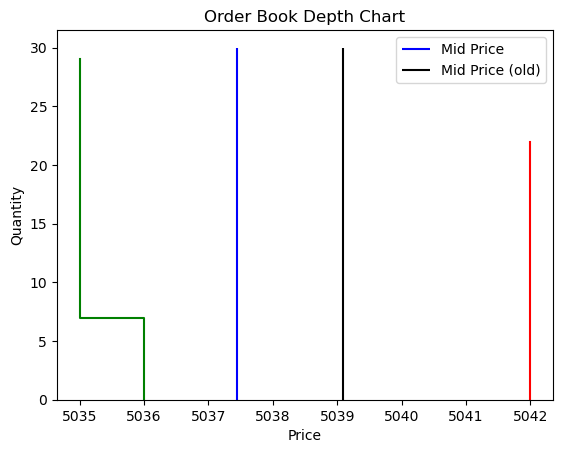

In [18]:
plot_orderbook(data, mid, mid_old)

# Amethysts


In [19]:
amethysts = prices[prices["product"] == "AMETHYSTS"].sort_values("timestamp")

amethysts.head()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss


In [20]:
amethysts["mid_price"].rolling(50).var().mean()

nan

In [21]:
# testing
GAMMA = 0.025
K = 0.25

SIGMA = np.sqrt(2.24)
T = 1
t = 0
S = 10_000  # current midprice

CURRENT_POS = -20
TARGET_POS = 0
Q = CURRENT_POS - TARGET_POS

r = stoikov_model_res_price(S, Q, GAMMA, SIGMA, T, t)
spread_sum = stoikov_model_spread(GAMMA, SIGMA, T, t, K)

print(r)  # 98 makes sense since we want to
print(spread_sum)


def get_bid_ask(res_price, spread):
    return res_price - spread / 2, res_price + spread / 2


bid, ask = get_bid_ask(r, spread_sum)
print(f"\ncurrent midprice is {S}, refprice is {r}")
print(f"bid: {bid:.2f}, ask: {ask:.2f}, spread: {ask - bid:.2f}")

10001.12
7.680814384345995

current midprice is 10000, refprice is 10001.12
bid: 9997.28, ask: 10004.96, spread: 7.68
